In [8]:
import io

import matplotlib.pyplot as plt
import pandas as pd
import requests
import statsmodels.api as sm

%matplotlib inline

In [3]:
url = 'http://robjhyndman.com/tsdldata/data/nybirths.dat'
fopen = requests.get(url).content
ds = pd.read_csv(
    io.StringIO(fopen.decode('utf-8')), header=None, names=['birthcount'])
ds.head()

,birthcount
0,26.663
1,23.598
2,26.931
3,24.740
4,25.806


In [5]:
ds['date'] = pd.date_range('1946-01-01', '1959-12-31', freq='1M')
ds.set_index('date', inplace=True)
ds.head()

,birthcount
date,
1946-01-31,26.663
1946-02-28,23.598
1946-03-31,26.931
1946-04-30,24.740
1946-05-31,25.806


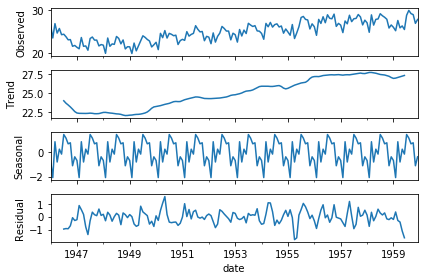

In [12]:
decomp = sm.tsa.seasonal_decompose(ds.birthcount, model='additive')
decomp.plot();